In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
import random
if not Path("helper_functions.py").is_file():
  print("Downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn
import numpy as np
device="cuda" if torch.cuda.is_available() else "cpu" #cuda uses gpu

In [ ]:
train_data=torchvision.datasets.CIFAR10(root = "data", download=True, train=True, transform=ToTensor())
test_data=torchvision.datasets.CIFAR10(root="data", download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
BATCH_SIZE=32
train_dataloader= DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)
class_names=train_data.classes

torch.Size([3, 32, 32])

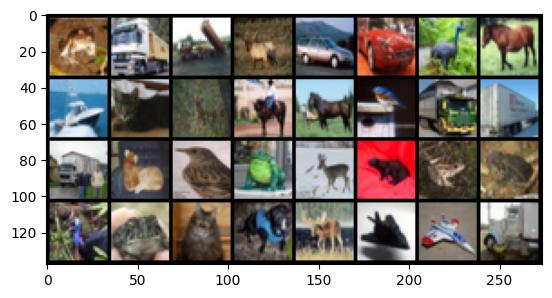

In [ ]:
images, labels = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(images)
def display_grid(grid):
  grid = grid.numpy()
  grid = np.transpose(grid, (1, 2, 0))
  plt.imshow(grid)
display_grid(grid)
images[0].shape

In [ ]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [ ]:
def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
classifier_model = resnet18()
classifier_model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=classifier_model.parameters(), lr=0.001)

In [ ]:
def train_step(model: nn.Module, data_loader: DataLoader, loss_fn:nn.Module, optimizer:torch.optim.Optimizer, accuracy_fn, device:torch.device=device):
  train_loss, train_acc=0, 0
  model.to(device)
  i = 0
  for batch, (X, y) in enumerate(data_loader):
    print(f"Running batch {i}")
    i+=1
    #send data to GPU
    X, y = X.to(device), y.to(device)
    #forward pass
    y_pred=model(X)
    #calculate loss
    loss=loss_fn(y_pred, y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) #go from logits to predicted labels
    #optimizer zero grad to clear the gradients from previous passes
    optimizer.zero_grad()
    #loss backward to calculate the gradients
    loss.backward()
    #optimizer step to update the weights
    optimizer.step()
  #per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(data_loader: torch.utils.data.DataLoader, model:nn.Module, loss_fn: nn.Module, accuracy_fn, device: torch.device=device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred=model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

In [ ]:
def print_train_time(start:float, end: float, device: torch.device=None):
  total_time=end-start
  print(f"Train time: {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
torch.manual_seed(10)
train_time_start_classifier_model=timer()

epochs = 20
#train and test classifier model
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n-----------------")
  train_step(data_loader=train_dataloader, model=classifier_model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
  test_step(data_loader=test_dataloader, model=classifier_model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

train_time_end_classifier_model=timer()
total_train_time_classifier_model=print_train_time(start=train_time_start_classifier_model, end=train_time_end_classifier_model, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Running batch 1267
Running batch 1268
Running batch 1269
Running batch 1270
Running batch 1271
Running batch 1272
Running batch 1273
Running batch 1274
Running batch 1275
Running batch 1276
Running batch 1277
Running batch 1278
Running batch 1279
Running batch 1280
Running batch 1281
Running batch 1282
Running batch 1283
Running batch 1284
Running batch 1285
Running batch 1286
Running batch 1287
Running batch 1288
Running batch 1289
Running batch 1290
Running batch 1291
Running batch 1292
Running batch 1293
Running batch 1294
Running batch 1295
Running batch 1296
Running batch 1297
Running batch 1298
Running batch 1299
Running batch 1300
Running batch 1301
Running batch 1302
Running batch 1303
Running batch 1304
Running batch 1305
Running batch 1306
Running batch 1307
Running batch 1308
Running batch 1309
Running batch 1310
Running batch 1311
Running batch 1312
Running batch 1313
Running batch 1314
Running batch 1315
Running batch 1316

In [ ]:
def make_predictions(model:nn.Module, data: list, device: torch.device=device):
  pred_probs=[]
  model.to(device).eval()
  with torch.inference_mode():
    for sample in data:
      sample=torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob=torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

[('automobile', 'automobile'), ('deer', 'deer'), ('horse', 'dog'), ('bird', 'bird'), ('deer', 'deer'), ('truck', 'ship'), ('cat', 'bird'), ('deer', 'deer'), ('horse', 'horse'), ('cat', 'cat'), ('truck', 'automobile'), ('horse', 'horse'), ('truck', 'truck'), ('cat', 'airplane'), ('truck', 'truck'), ('truck', 'bird'), ('frog', 'dog'), ('truck', 'automobile'), ('deer', 'bird'), ('airplane', 'airplane')]


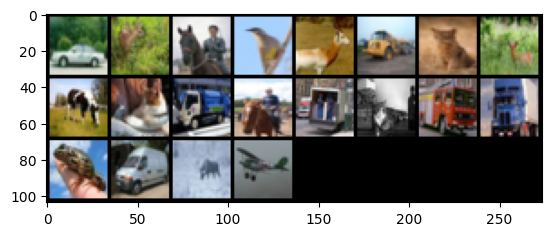

In [ ]:
test_samples=[]
test_labels=[]
for sample, label in random.sample(list(test_data), k=20):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs=make_predictions(model=classifier_model, data=test_samples, device=device)
pred_probs[:2]

pred_classes=pred_probs.argmax(dim=1)
pred_classes
test_labels, pred_classes
prediction_comparisons = []
actual_labels = []
predicted_labels = []
for val in test_labels:
  actual_labels += [class_names[val]]
for val in pred_classes:
  predicted_labels += [class_names[val]]
actual_labels
for i, val in enumerate(test_labels):
  prediction_comparisons += [(actual_labels[i], predicted_labels[i])]
print(prediction_comparisons)
grid = torchvision.utils.make_grid(test_samples)
def display_grid(grid):
  grid = grid.numpy()
  grid = np.transpose(grid, (1, 2, 0))
  plt.imshow(grid)
display_grid(grid)